# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import json
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from langdetect import detect
import spacy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, precision_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import pendulum

In [2]:
def confusion_matrix_plot(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

def report(y_true, y_pred, class_names=['no_spoiler', 'spoiler']):
    print(classification_report(y_true, y_pred, target_names=class_names))
    confusion_matrix_plot(y_true, y_pred, class_names)

# Select top 10 reviews films

In [3]:
merged_df = pd.read_parquet('./data/full_dataframe.parquet')

In [4]:
merged_df.groupby('movie_id').count().sort_values(by='is_spoiler', ascending=False)[:10]

,plot_summary,duration,genre,film_rating,release_date,plot_synopsis,summary_char_count,summary_word_count,summary_entity_count,summary_unique_entities,...,review_text,reviewer_rating,review_summary,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_tokens,review_token_count
movie_id,,,,,,,,,,,,,,,,,,,,,
tt0468569,4845,4845,4845,4845,4845,4845,4845,4845,4845,4845,...,4845,4845,4845,4845,4845,4845,4845,4845,4845,4845
tt0111161,4361,4361,4361,4361,4361,4361,4361,4361,4361,4361,...,4361,4361,4361,4361,4361,4361,4361,4361,4361,4361
tt0167260,2729,2729,2729,2729,2729,2729,2729,2729,2729,2729,...,2729,2729,2729,2729,2729,2729,2729,2729,2729,2729
tt0137523,2480,2480,2480,2480,2480,2480,2480,2480,2480,2480,...,2480,2480,2480,2480,2480,2480,2480,2480,2480,2480
tt0068646,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137,...,2137,2137,2137,2137,2137,2137,2137,2137,2137,2137
tt0110912,1994,1994,1994,1994,1994,1994,1994,1994,1994,1994,...,1994,1994,1994,1994,1994,1994,1994,1994,1994,1994
tt0108052,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151,...,1151,1151,1151,1151,1151,1151,1151,1151,1151,1151
tt0050083,916,916,916,916,916,916,916,916,916,916,...,916,916,916,916,916,916,916,916,916,916
tt0803096,751,751,751,751,751,751,751,751,751,751,...,751,751,751,751,751,751,751,751,751,751


In [5]:
# set up list of review count values
review_counts = list(merged_df.groupby('movie_id').count().sort_values(by='is_spoiler', ascending=False).plot_summary[:10].values)
# set up list of movie_ids
most_reviewed_movie_ids = list(merged_df.groupby('movie_id').count().sort_values(by='is_spoiler', ascending=False)[:10].index)
# save the list of movie ids as a pickle file for easier import later
with open('top_10_movie_ids.pkl', 'wb') as f:
    pickle.dump(most_reviewed_movie_ids, f)

In [6]:
sum(review_counts)/len(merged_df)

0.03853371504043296

Top 10 most reviews films represent 22,115 reviews, about 3.8 percent of our total reviews. We then searched google for the title associated with the movie_id.

In [7]:
# create list of movie titles
most_reviewed_movie_titles = ['The Dark Knight',
                              'The Shawshank Redemption',
                              'The Lord of the Rings: The Return of the King',
                              'Fight Club',
                              'The Godfather',
                              'Pulp Fiction',
                              "Schindler's List",
                              '12 Angry Men',
                              'Warcraft',
                              'Mother!']

In [8]:
print(round(merged_df[merged_df.movie_id == 'tt0468569'].is_spoiler.value_counts(normalize=True)*100, 2))

False    69.41
True     30.59
Name: is_spoiler, dtype: float64


In [9]:
for i, v in enumerate(most_reviewed_movie_ids):
    print(f"Film: {most_reviewed_movie_titles[i]}")
    print(f"Total reviews: {review_counts[i]}")
    print("Spoiler distribution:")
    print(round(merged_df[merged_df.movie_id == v].is_spoiler.value_counts(normalize=True)*100, 2))
    print("---------------------------------------------")

Film: The Dark Knight
Total reviews: 4845
Spoiler distribution:
False    69.41
True     30.59
Name: is_spoiler, dtype: float64
---------------------------------------------
Film: The Shawshank Redemption
Total reviews: 4361
Spoiler distribution:
False    78.08
True     21.92
Name: is_spoiler, dtype: float64
---------------------------------------------
Film: The Lord of the Rings: The Return of the King
Total reviews: 2729
Spoiler distribution:
False    82.04
True     17.96
Name: is_spoiler, dtype: float64
---------------------------------------------
Film: Fight Club
Total reviews: 2480
Spoiler distribution:
False    81.49
True     18.51
Name: is_spoiler, dtype: float64
---------------------------------------------
Film: The Godfather
Total reviews: 2137
Spoiler distribution:
False    80.35
True     19.65
Name: is_spoiler, dtype: float64
---------------------------------------------
Film: Pulp Fiction
Total reviews: 1994
Spoiler distribution:
False    80.09
True     19.91
Name: is_spo

In [10]:
del merged_df

# Data Preparation

In [3]:
# load all reviews
review_df = pd.read_parquet('./data/reviews_lemmed.parquet')
# open pickle file with top 10 reviews films' movie ids
with open('top_10_movie_ids.pkl', 'rb') as f:
    most_reviewed_movie_ids = pickle.load(f)
# create a new dataframe of reviews for those 10 films
top_ten_reviews = review_df[review_df.movie_id.isin(most_reviewed_movie_ids)][['movie_id', 'is_spoiler', 'review_text_lemmed']].copy()
top_ten_reviews.reset_index(drop=True, inplace=True)
# delete the larger dataframe
del review_df
# display the new dataframe
top_ten_reviews

,movie_id,is_spoiler,review_text_lemmed
0,tt0111161,1,oscar year shawshank redemption write direct f...
1,tt0111161,1,shawshank redemption without doubt one brillia...
2,tt0111161,1,believe film best story ever tell film i'm tel...
3,tt0111161,1,yes spoiler film emotional impact find hard wr...
4,tt0111161,1,heart extraordinary movie brilliant indelible ...
...,...,...,...
22110,tt0110912,0,know people planet maybe like movie much hones...
22111,tt0110912,0,love everything movie always enjoy one list st...
22112,tt0110912,0,quentin tarantino's pulp fiction terrible star...
22113,tt0110912,0,lot people think movie masterpiece decide watc...


In [4]:
top_ten_reviews.is_spoiler.value_counts(normalize=True)

0    0.770473
1    0.229527
Name: is_spoiler, dtype: float64

## Train/Test split

In [30]:
# set X to the review text lemmed, y to target
X = top_ten_reviews.review_text_lemmed
y = top_ten_reviews.is_spoiler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [32]:
# helper function to transform the training and validation data
def transformX(vectorizer, train=X_train, val=X_test, train_target=y_train, val_target=y_test):
    # fit/transform training data
    train_vec = vectorizer.fit_transform(train)
    train_vec = pd.DataFrame.sparse.from_spmatrix(train_vec)
    train_vec.columns = sorted(vectorizer.vocabulary_)
    train_vec.set_index(train_target.index, inplace=True)
    # transform validation data
    val_vec = vectorizer.transform(val)
    val_vec = pd.DataFrame.sparse.from_spmatrix(val_vec)
    val_vec.columns = sorted(vectorizer.vocabulary_)
    val_vec.set_index(val_target.index, inplace=True)
    # return both dataframes
    return train_vec, val_vec

# Modeling

## tfidf more than 5 appearances

In [39]:
# set tfidf vectorizer, default parameters
base_tfidf = TfidfVectorizer(min_df=5)

X_train_tfidf, X_test_tfidf = transformX(base_tfidf)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    report(y_test, y_pred)

              precision    recall  f1-score   support

  no_spoiler       0.78      0.99      0.87      3405
     spoiler       0.59      0.06      0.11      1018

    accuracy                           0.77      4423
   macro avg       0.69      0.52      0.49      4423
weighted avg       0.74      0.77      0.69      4423



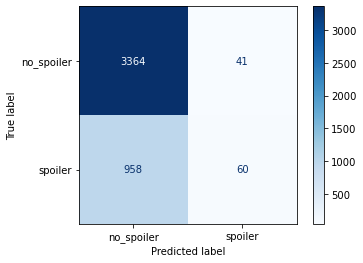

In [40]:
# instantiate multinomial naive bayes model
mnb_v1 = MultinomialNB()
# fit, predict and report with helper function
fitpredreport(mnb_v1)

[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.82      0.93      0.87      3405
     spoiler       0.59      0.32      0.42      1018

    accuracy                           0.79      4423
   macro avg       0.71      0.63      0.64      4423
weighted avg       0.77      0.79      0.77      4423



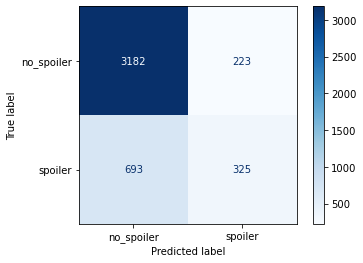

In [41]:
# instantiate logistic regression model
lr_v1 = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
# fit, predict and report with helper function
fitpredreport(lr_v1)

              precision    recall  f1-score   support

  no_spoiler       0.82      0.92      0.87      3405
     spoiler       0.55      0.34      0.42      1018

    accuracy                           0.78      4423
   macro avg       0.69      0.63      0.64      4423
weighted avg       0.76      0.78      0.76      4423



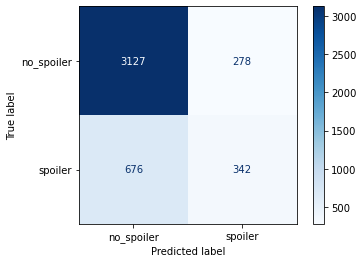

In [42]:
# instantiate SVM model
svm_v1 = LinearSVC(random_state=42)
# fit, predict and report with helper function
fitpredreport(svm_v1)

              precision    recall  f1-score   support

  no_spoiler       0.78      0.99      0.87      3405
     spoiler       0.64      0.05      0.09      1018

    accuracy                           0.78      4423
   macro avg       0.71      0.52      0.48      4423
weighted avg       0.75      0.78      0.69      4423



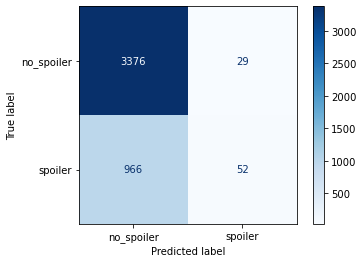

In [43]:
# instantiate random forest classifier
rf_v1 = RandomForestClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v1)

              precision    recall  f1-score   support

  no_spoiler       0.82      0.94      0.87      3405
     spoiler       0.59      0.30      0.39      1018

    accuracy                           0.79      4423
   macro avg       0.70      0.62      0.63      4423
weighted avg       0.77      0.79      0.76      4423



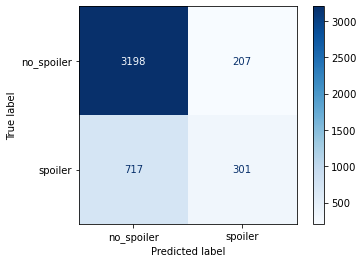

In [34]:
# instantiate XGB classifier
xgb_v1 = XGBClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(xgb_v1)

## tfidf bi grams more than 5 appearances

In [44]:
# set tfidf vectorizer, default parameters
tfidf_bigrams = TfidfVectorizer(min_df=5, ngram_range=(1,2))

X_train_tfidf, X_test_tfidf = transformX(tfidf_bigrams)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    report(y_test, y_pred)

              precision    recall  f1-score   support

  no_spoiler       0.77      1.00      0.87      3405
     spoiler       0.53      0.02      0.04      1018

    accuracy                           0.77      4423
   macro avg       0.65      0.51      0.45      4423
weighted avg       0.72      0.77      0.68      4423



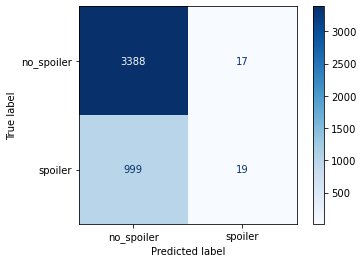

In [49]:
# instantiate multinomial naive bayes model
mnb_v2 = MultinomialNB()
# fit, predict and report with helper function
fitpredreport(mnb_v2)

[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.82      0.94      0.87      3405
     spoiler       0.60      0.29      0.39      1018

    accuracy                           0.79      4423
   macro avg       0.71      0.61      0.63      4423
weighted avg       0.76      0.79      0.76      4423



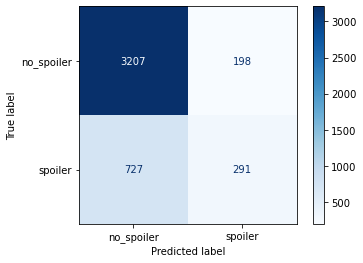

In [50]:
# instantiate logistic regression model
lr_v2 = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
# fit, predict and report with helper function
fitpredreport(lr_v2)

              precision    recall  f1-score   support

  no_spoiler       0.82      0.93      0.87      3405
     spoiler       0.56      0.31      0.40      1018

    accuracy                           0.79      4423
   macro avg       0.69      0.62      0.63      4423
weighted avg       0.76      0.79      0.76      4423



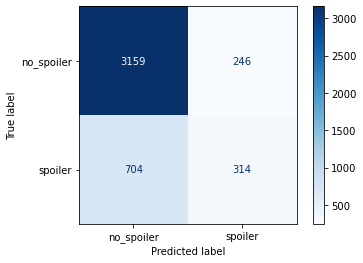

In [51]:
# instantiate SVM model
svm_v2 = LinearSVC(random_state=42)
# fit, predict and report with helper function
fitpredreport(svm_v2)

              precision    recall  f1-score   support

  no_spoiler       0.78      0.99      0.87      3405
     spoiler       0.57      0.04      0.07      1018

    accuracy                           0.77      4423
   macro avg       0.67      0.51      0.47      4423
weighted avg       0.73      0.77      0.69      4423



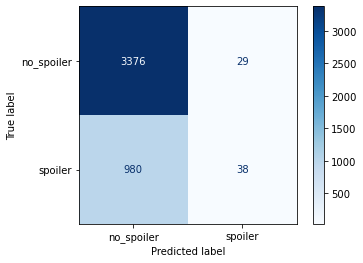

In [52]:
# instantiate random forest classifier
rf_v2 = RandomForestClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v2)

              precision    recall  f1-score   support

  no_spoiler       0.81      0.95      0.88      3405
     spoiler       0.62      0.28      0.39      1018

    accuracy                           0.79      4423
   macro avg       0.72      0.61      0.63      4423
weighted avg       0.77      0.79      0.76      4423



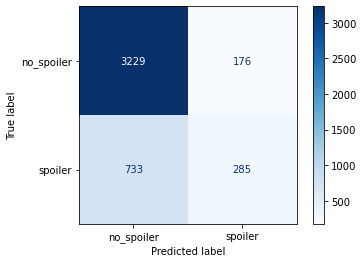

In [36]:
# instantiate XGB classifier
xgb_v2 = XGBClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(xgb_v2)

## tfidf tri grams more than 5 appearances

In [53]:
# set tfidf vectorizer, default parameters
tfidf_trigrams = TfidfVectorizer(min_df=5, ngram_range=(1,3))

X_train_tfidf, X_test_tfidf = transformX(tfidf_trigrams)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    report(y_test, y_pred)

              precision    recall  f1-score   support

  no_spoiler       0.77      0.99      0.87      3405
     spoiler       0.47      0.03      0.05      1018

    accuracy                           0.77      4423
   macro avg       0.62      0.51      0.46      4423
weighted avg       0.70      0.77      0.68      4423



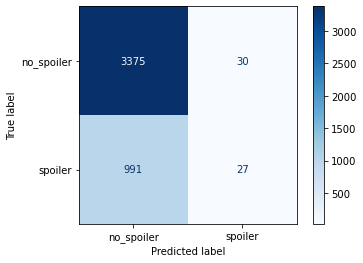

In [54]:
# instantiate multinomial naive bayes model
mnb_v3 = MultinomialNB()
# fit, predict and report with helper function
fitpredreport(mnb_v3)

[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.81      0.94      0.87      3405
     spoiler       0.60      0.28      0.38      1018

    accuracy                           0.79      4423
   macro avg       0.70      0.61      0.63      4423
weighted avg       0.76      0.79      0.76      4423



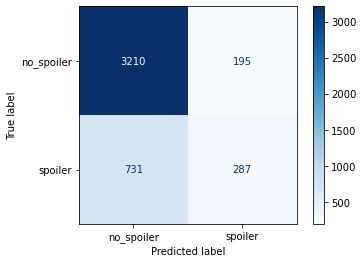

In [55]:
# instantiate logistic regression model
lr_v3 = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
# fit, predict and report with helper function
fitpredreport(lr_v3)

              precision    recall  f1-score   support

  no_spoiler       0.82      0.93      0.87      3405
     spoiler       0.57      0.32      0.41      1018

    accuracy                           0.79      4423
   macro avg       0.70      0.62      0.64      4423
weighted avg       0.76      0.79      0.76      4423



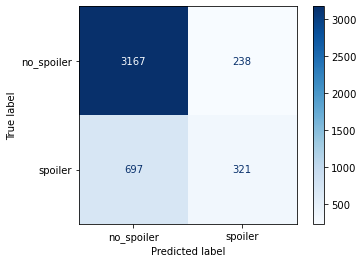

In [56]:
# instantiate SVM model
svm_v3 = LinearSVC(random_state=42)
# fit, predict and report with helper function
fitpredreport(svm_v3)

              precision    recall  f1-score   support

  no_spoiler       0.78      0.99      0.87      3405
     spoiler       0.64      0.04      0.07      1018

    accuracy                           0.77      4423
   macro avg       0.71      0.51      0.47      4423
weighted avg       0.74      0.77      0.69      4423



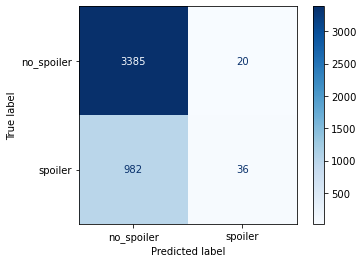

In [57]:
# instantiate random forest classifier
rf_v3 = RandomForestClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v3)

              precision    recall  f1-score   support

  no_spoiler       0.82      0.94      0.88      3405
     spoiler       0.61      0.29      0.40      1018

    accuracy                           0.79      4423
   macro avg       0.71      0.62      0.64      4423
weighted avg       0.77      0.79      0.77      4423



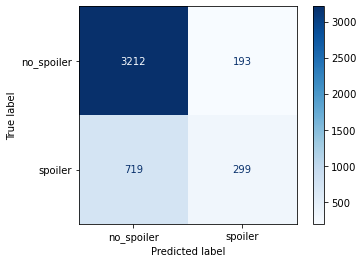

In [38]:
xgb_v3 = XGBClassifier(random_state=42, n_jobs=-1)
fitpredreport(xgb_v3)

## tfidf more than 7 appearances

In [59]:
# set tfidf vectorizer, default parameters
tfidf_trigrams = TfidfVectorizer(min_df=7)

X_train_tfidf, X_test_tfidf = transformX(tfidf_trigrams)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    report(y_test, y_pred)

              precision    recall  f1-score   support

  no_spoiler       0.78      0.99      0.87      3405
     spoiler       0.60      0.07      0.13      1018

    accuracy                           0.78      4423
   macro avg       0.69      0.53      0.50      4423
weighted avg       0.74      0.78      0.70      4423



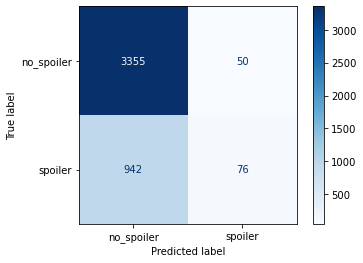

In [60]:
# instantiate multinomial naive bayes model
mnb_v4 = MultinomialNB()
# fit, predict and report with helper function
fitpredreport(mnb_v4)

[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.82      0.93      0.87      3405
     spoiler       0.59      0.32      0.41      1018

    accuracy                           0.79      4423
   macro avg       0.71      0.63      0.64      4423
weighted avg       0.77      0.79      0.77      4423



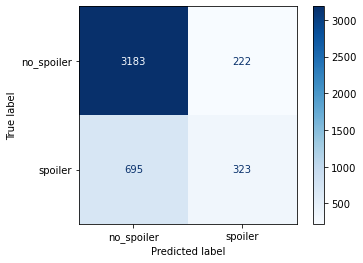

In [61]:
# instantiate logistic regression model
lr_v4 = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
# fit, predict and report with helper function
fitpredreport(lr_v4)

              precision    recall  f1-score   support

  no_spoiler       0.82      0.92      0.87      3405
     spoiler       0.54      0.33      0.41      1018

    accuracy                           0.78      4423
   macro avg       0.68      0.62      0.64      4423
weighted avg       0.76      0.78      0.76      4423



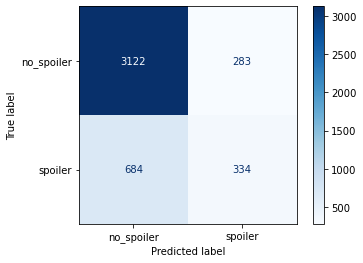

In [62]:
# instantiate SVM model
svm_v4 = LinearSVC(random_state=42)
# fit, predict and report with helper function
fitpredreport(svm_v4)

              precision    recall  f1-score   support

  no_spoiler       0.78      0.99      0.87      3405
     spoiler       0.69      0.07      0.12      1018

    accuracy                           0.78      4423
   macro avg       0.73      0.53      0.50      4423
weighted avg       0.76      0.78      0.70      4423



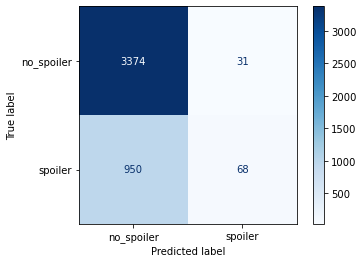

In [63]:
# instantiate random forest classifier
rf_v4 = RandomForestClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v4)

              precision    recall  f1-score   support

  no_spoiler       0.82      0.95      0.88      3405
     spoiler       0.61      0.29      0.39      1018

    accuracy                           0.79      4423
   macro avg       0.71      0.62      0.63      4423
weighted avg       0.77      0.79      0.76      4423



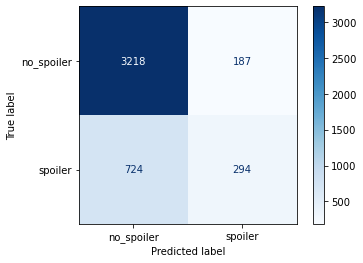

In [64]:
xgb_v4 = XGBClassifier(random_state=42, n_jobs=-1)
fitpredreport(xgb_v4)

# Cosine Similarity with movie summary

In [4]:
summary_df = pd.read_parquet('./data/plot_summary_lemmed.parquet')
top_ten_summaries = summary_df[summary_df.movie_id.isin(most_reviewed_movie_ids)][['movie_id', 'plot_summary_lemmed']].copy()
del summary_df
top_ten_summaries

,movie_id,plot_summary_lemmed
0,tt0111161,chronicle experience formerly successful banke...
1,tt0068646,age head famous crime family decide transfer p...
3,tt0468569,set within year event batman begin batman lieu...
4,tt0050083,defense prosecution rest jury filing jury room...
5,tt0108052,oskar schindler vainglorious greedy german bus...
6,tt0110912,jules winnfield samuel l jackson vincent vega ...
7,tt0167260,final confrontation force good evil fight cont...
9,tt0137523,nameless first person narrator edward norton a...
253,tt5109784,couple's relationship test uninvited guest arr...
592,tt0803096,world orcs draenor destroy evil fel magic use ...


In [5]:
top_ten_reviews = pd.merge(top_ten_reviews, top_ten_summaries, on='movie_id', how='left')
top_ten_reviews

,movie_id,is_spoiler,review_text_lemmed,plot_summary_lemmed
0,tt0111161,1,oscar year shawshank redemption write direct f...,chronicle experience formerly successful banke...
1,tt0111161,1,shawshank redemption without doubt one brillia...,chronicle experience formerly successful banke...
2,tt0111161,1,believe film best story ever tell film i'm tel...,chronicle experience formerly successful banke...
3,tt0111161,1,yes spoiler film emotional impact find hard wr...,chronicle experience formerly successful banke...
4,tt0111161,1,heart extraordinary movie brilliant indelible ...,chronicle experience formerly successful banke...
...,...,...,...,...
22110,tt0110912,0,know people planet maybe like movie much hones...,jules winnfield samuel l jackson vincent vega ...
22111,tt0110912,0,love everything movie always enjoy one list st...,jules winnfield samuel l jackson vincent vega ...
22112,tt0110912,0,quentin tarantino's pulp fiction terrible star...,jules winnfield samuel l jackson vincent vega ...
22113,tt0110912,0,lot people think movie masterpiece decide watc...,jules winnfield samuel l jackson vincent vega ...


## testing

In [33]:
whole_df = pd.read_parquet('./data/full_dataframe.parquet')

In [34]:
whole_df.plot_synopsis

0         In 1947, Andy Dufresne (Tim Robbins), a banker...
1         In 1947, Andy Dufresne (Tim Robbins), a banker...
2         In 1947, Andy Dufresne (Tim Robbins), a banker...
3         In 1947, Andy Dufresne (Tim Robbins), a banker...
4         In 1947, Andy Dufresne (Tim Robbins), a banker...
                                ...                        
573908    The film is told out of chronological format, ...
573909    The film is told out of chronological format, ...
573910    The film is told out of chronological format, ...
573911    The film is told out of chronological format, ...
573912    The film is told out of chronological format, ...
Name: plot_synopsis, Length: 573913, dtype: object

In [35]:
with open('no_synopsis_ids.pkl', 'rb') as f:
    no_synopsis_ids = pickle.load(f)

In [40]:
whole_df[whole_df.movie_id.isin(no_synopsis_ids)]

,movie_id,plot_summary,duration,genre,film_rating,release_date,plot_synopsis,summary_char_count,summary_word_count,summary_entity_count,...,review_text,reviewer_rating,review_summary,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_tokens,review_token_count
30226,tt2380307,Despite his family's baffling generations-old ...,105,"[Animation, Adventure, Comedy]",8.7,2017-11-21,,485,88,5,...,Well Disney and pixar really make such a great...,10,My Favorite Animation Movie of the year,557,105,5,4,1.25,"[well, disney, pixar, really, make, great, mov...",59
30227,tt2380307,Despite his family's baffling generations-old ...,105,"[Animation, Adventure, Comedy]",8.7,2017-11-21,,485,88,5,...,"One of the best movie ever, it is an amazing a...",10,Perfect Movie Ever,344,67,5,4,1.25,"[one, best, movie, ever, amazing, animated, mo...",36
30228,tt2380307,Despite his family's baffling generations-old ...,105,"[Animation, Adventure, Comedy]",8.7,2017-11-21,,485,88,5,...,It's not a secret that every time Disney's Pix...,8,Disney did it again! A heartwarming and dazzli...,2466,450,18,12,1.50,"[secret, every, time, disney's, pixar, make, p...",225
30229,tt2380307,Despite his family's baffling generations-old ...,105,"[Animation, Adventure, Comedy]",8.7,2017-11-21,,485,88,5,...,I did not watch this in 3D.Before I begin with...,5,"Sorry, but mostly a Snoozefest.",4472,823,34,23,1.48,"[watch, begin, coco, would, like, state, froze...",389
30230,tt2380307,Despite his family's baffling generations-old ...,105,"[Animation, Adventure, Comedy]",8.7,2017-11-21,,485,88,5,...,"Taking place in contemporary Mexico, in a fict...",10,A beautiful story and a faithful depiction of ...,1345,231,11,11,1.00,"[taking, place, contemporary, mexico, fictiona...",131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573094,tt0157503,"In a small Minnesota town, the annual beauty p...",97,"[Comedy, Romance, Thriller]",6.6,1999-07-23,,507,95,6,...,Drop Dead Gorgeous is an unfortunate entry int...,3,a misguided attempt at comedy,2006,326,16,14,1.14,"[drop, dead, gorgeous, unfortunate, entry, moc...",182
573095,tt0157503,"In a small Minnesota town, the annual beauty p...",97,"[Comedy, Romance, Thriller]",6.6,1999-07-23,,507,95,6,...,"There is not one surprise in this movie, it is...",1,This movie sucks bigtime...,176,37,0,0,0.00,"[one, surprise, movie, one, worst, movies, eve...",14
573096,tt0157503,"In a small Minnesota town, the annual beauty p...",97,"[Comedy, Romance, Thriller]",6.6,1999-07-23,,507,95,6,...,Well where do I begin ? I must say before any ...,4,It had its' moments....,501,96,4,2,2.00,"[well, begin, must, say, comment, may, movie, ...",44
573097,tt0157503,"In a small Minnesota town, the annual beauty p...",97,"[Comedy, Romance, Thriller]",6.6,1999-07-23,,507,95,6,...,Denise Richards is hilarious as a ruthless tee...,5,Uneven,534,95,2,2,1.00,"[denise, richards, hilarious, ruthless, teen, ...",57


In [39]:
whole_df[~whole_df.movie_id.isin(no_synopsis_ids)]

,movie_id,plot_summary,duration,genre,film_rating,release_date,plot_synopsis,summary_char_count,summary_word_count,summary_entity_count,...,review_text,reviewer_rating,review_summary,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_tokens,review_token_count
0,tt0111161,Chronicles the experiences of a formerly succe...,142,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",386,77,1,...,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,4751,843,56,44,1.27,"[oscar, year, shawshank, redemption, written, ...",441
1,tt0111161,Chronicles the experiences of a formerly succe...,142,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",386,77,1,...,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,1218,223,20,19,1.05,"[shawshank, redemption, without, doubt, one, b...",110
2,tt0111161,Chronicles the experiences of a formerly succe...,142,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",386,77,1,...,I believe that this film is the best story eve...,8,The best story ever told on film,1470,250,9,6,1.50,"[believe, film, best, story, ever, told, film,...",145
3,tt0111161,Chronicles the experiences of a formerly succe...,142,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",386,77,1,...,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,4096,766,6,6,1.00,"[yes, spoilers, film, emotional, impact, find,...",347
4,tt0111161,Chronicles the experiences of a formerly succe...,142,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker...",386,77,1,...,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",4632,829,52,45,1.16,"[heart, extraordinary, movie, brilliant, indel...",411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573908,tt0139239,"Told from three perspectives, a story of a bun...",102,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",260,55,4,...,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties,317,52,2,2,1.00,"[go, wise, fast, pure, entertainment, assembli...",32
573909,tt0139239,"Told from three perspectives, a story of a bun...",102,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",260,55,4,...,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie,302,54,2,2,1.00,"[well, shall, say, one, fun, rate, three, plot...",31
573910,tt0139239,"Told from three perspectives, a story of a bun...",102,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",260,55,4,...,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen,1044,202,10,9,1.11,"[go, best, movie, ever, seen, i've, seen, lot,...",107
573911,tt0139239,"Told from three perspectives, a story of a bun...",102,"[Comedy, Crime]",7.3,1999-04-09,"The film is told out of chronological format, ...",260,55,4,...,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?,507,89,7,7,1.00,"[call, teenage, version, pulp, fiction, whatev...",47


In [ ]:
sw = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
lemmatizer = nltk.stem.WordNetLemmatizer()

# helper function to correctly format the part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# helper function to clean and lemmatize the summary
def lem_summary(df):
    # get the doc text
    doc = df.plot_summary
    # tokenize the doc, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the doc
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned doc
    return doc_cleaned

In [8]:
# testing with the film with the most reviews: shawshank redemption
shawshank = top_ten_reviews[top_ten_reviews.movie_id == 'tt0111161'].copy()
shawshank

,movie_id,is_spoiler,review_text_lemmed,plot_summary_lemmed
0,tt0111161,1,oscar year shawshank redemption write direct f...,chronicle experience formerly successful banke...
1,tt0111161,1,shawshank redemption without doubt one brillia...,chronicle experience formerly successful banke...
2,tt0111161,1,believe film best story ever tell film i'm tel...,chronicle experience formerly successful banke...
3,tt0111161,1,yes spoiler film emotional impact find hard wr...,chronicle experience formerly successful banke...
4,tt0111161,1,heart extraordinary movie brilliant indelible ...,chronicle experience formerly successful banke...
...,...,...,...,...
4356,tt0111161,0,movie really need hour develop story think sha...,chronicle experience formerly successful banke...
4357,tt0111161,0,due respect people complain stark good v evil ...,chronicle experience formerly successful banke...
4358,tt0111161,0,every single scene shawshank redemption every ...,chronicle experience formerly successful banke...
4359,tt0111161,0,begin think would another annoy movie i've tot...,chronicle experience formerly successful banke...


In [29]:
len(list(shawshank.review_text_lemmed))

4361

In [32]:
shawshank.iloc[0].plot_summary_lemmed

"chronicle experience formerly successful banker prisoner gloomy jailhouse shawshank find guilty crime commit film portrays man's unique way deal new torturous life along way befriends number fellow prisoner notably wise long term inmate name red write j golden"

In [31]:
corpus = shawshank.review_text_lemmed.str.cat(sep=' ')

In [ ]:
# helper function to transform the training and validation data
def transformX(vectorizer, train=X_train, val=X_val, train_target=y_train, val_target=y_val):
    # fit/transform training data
    train_vec = vectorizer.fit_transform(train)
    train_vec = pd.DataFrame.sparse.from_spmatrix(train_vec)
    train_vec.columns = sorted(vectorizer.vocabulary_)
    train_vec.set_index(train_target.index, inplace=True)
    # transform validation data
    val_vec = vectorizer.transform(val)
    val_vec = pd.DataFrame.sparse.from_spmatrix(val_vec)
    val_vec.columns = sorted(vectorizer.vocabulary_)
    val_vec.set_index(val_target.index, inplace=True)
    # return both dataframes
    return train_vec, val_vec

In [ ]:
shawshank_summary = 

In [22]:
def combine_review_plot(row):
    return row['review_text_lemmed'] + row['plot_summary_lemmed']

shawshank['combined_review_plot'] = shawshank.apply(combine_review_plot, axis=1)

In [24]:
df = shawshank[['is_spoiler', 'combined_review_plot']].copy()
df

,is_spoiler,combined_review_plot
0,1,oscar year shawshank redemption write direct f...
1,1,shawshank redemption without doubt one brillia...
2,1,believe film best story ever tell film i'm tel...
3,1,yes spoiler film emotional impact find hard wr...
4,1,heart extraordinary movie brilliant indelible ...
...,...,...
4356,0,movie really need hour develop story think sha...
4357,0,due respect people complain stark good v evil ...
4358,0,every single scene shawshank redemption every ...
4359,0,begin think would another annoy movie i've tot...


In [9]:
shawshank.is_spoiler.value_counts(normalize=True)

0    0.780784
1    0.219216
Name: is_spoiler, dtype: float64

In [11]:
plot_cv = CountVectorizer()

In [16]:
plot_matrix = plot_cv.fit_transform(shawshank.plot_summary_lemmed)

In [21]:
plot_matrix.toarray()[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1], dtype=int64)

In [20]:
plot_matrix.toarray()[2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1], dtype=int64)

# BERT

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [25]:
!pip install -q -U "tensorflow-text==2.8.*"

In [26]:
!pip install -q tf-models-official==2.7.0

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\brtra\anaconda3\python.exe' 'C:\Users\brtra\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' build_wheel 'C:\Users\brtra\AppData\Local\Temp\tmp9vssf_mj'
       cwd: C:\Users\brtra\AppData\Local\Temp\pip-install-2_dhd4o0\pycocotools_943b44aa6f734ff2a06e32aae523675c
  Complete output (14 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\coco.py -> build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\cocoeval.py -> build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\mask.py -> build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\__init__.py -> build\lib.win-amd64-cpython-39\pycocotools
  running build_ext
  skipping 'pycocotools\_mask.c' Cython extension (up-to-date)
  building 'pycocotools._mask' extension
  e

In [27]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

ModuleNotFoundError: No module named 'official'